In [11]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from datetime import datetime,timedelta
import time
import pandas_datareader.data as web
from collections import Counter

In [4]:
test = pd.read_csv("Result/AAPL_TEST.csv")

# HISTOGRAMS

In [21]:
x1 = np.array(test['Return'].dropna())
bin_eval, bin_size = np.linspace(-0.1,0.1,10000,retstep=True)
freq, bins = np.histogram(x1, bins=bin_eval, density=False)
hist_den = np.array(freq)/len(x1)
hist_cum = np.cumsum(hist_den)
x_eval=np.linspace(-0.1+bin_size,0.1,9999, endpoint=False)

# KERNEL PDF ESTIMATION

KeyboardInterrupt: 

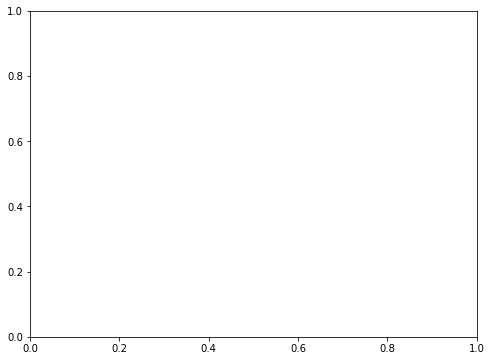

In [23]:
def my_kde_bandwidth(obj, fac=1./5):
    """We use Scott's Rule, multiplied by a constant factor."""
    return np.power(obj.n, -1./(obj.d+4)) * fac

kde = stats.gaussian_kde(x1)
kde2 = stats.gaussian_kde(x1, bw_method='silverman')
kde3 = stats.gaussian_kde(x1, bw_method=partial(my_kde_bandwidth, fac=0.2))
kde4 = stats.gaussian_kde(x1, bw_method=partial(my_kde_bandwidth, fac=0.5))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_eval, kde(x_eval), 'k-', label="Scott's Rule")
ax.plot(x_eval, kde2(x_eval), 'b-', label="Silverman's Rule")
ax.plot(x_eval, kde3(x_eval), 'g-', label="Scott * 0.2")
ax.plot(x_eval, kde4(x_eval), 'c-', label="Scott * 0.5")
ax.bar(x_eval, freq, width=bin_size, fc='gray', edgecolor ='gray', label="Histogram")

ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel('x')
ax.set_ylabel('Density')
plt.show()

# BANDWIDTHS

In [24]:
import numpy as np
from scipy.stats import scoreatpercentile
from statsmodels.sandbox.nonparametric import kernels

def _select_sigma(x, percentile=25):
    """
    Returns the smaller of std(X, ddof=1) or normalized IQR(X) over axis 0.
    References
    ----------
    Silverman (1986) p.47
    """
    # normalize = norm.ppf(.75) - norm.ppf(.25)
    normalize = 1.349
    IQR = (scoreatpercentile(x, 75) - scoreatpercentile(x, 25)) / normalize
    std_dev = np.std(x, axis=0, ddof=1)
    if IQR > 0:
        return np.minimum(std_dev, IQR)
    else:
        return std_dev

def bw_silverman(x, kernel=None):
    """
    Silverman's Rule of Thumb
    Parameters
    ----------
    x : array_like
        Array for which to get the bandwidth
    kernel : CustomKernel object
        Unused
    Returns
    -------
    bw : float
        The estimate of the bandwidth
    Notes
    -----
    Returns .9 * A * n ** (-1/5.) where ::
       A = min(std(x, ddof=1), IQR/1.349)
       IQR = np.subtract.reduce(np.percentile(x, [75,25]))
    References
    ----------
    Silverman, B.W. (1986) `Density Estimation.`
    """
    A = _select_sigma(x)
    n = len(x)
    return .9 * A * n ** (-0.2)
## Univariate Rule of Thumb Bandwidths ##
def bw_scott(x, kernel=None):
    """
    Scott's Rule of Thumb
    Parameters
    ----------
    x : array_like
        Array for which to get the bandwidth
    kernel : CustomKernel object
        Unused
    Returns
    -------
    bw : float
        The estimate of the bandwidth
    Notes
    -----
    Returns 1.059 * A * n ** (-1/5.) where ::
       A = min(std(x, ddof=1), IQR/1.349)
       IQR = np.subtract.reduce(np.percentile(x, [75,25]))
    References
    ----------
    Scott, D.W. (1992) Multivariate Density Estimation: Theory, Practice, and
        Visualization.
    """
    A = _select_sigma(x)
    n = len(x)
    return 1.059 * A * n ** (-0.2)

# KERNEL CDF ESTIMATION

In [25]:
from scipy.stats import norm
def kcu(x1,x_eval,bandwidth):
    total_result = []
    for i in x_eval:
        if bandwidth != 0:
            diff = [(i - x)/bandwidth for x in x1] 
            cdf_diff = norm.cdf(diff)
            result = np.mean(cdf_diff)
            total_result.append(result)
    return total_result
# Here to change the Bandwidth , 
bandwidth_1 = bw_silverman(x1,kernel='gaussian')
bandwidth_2 = bw_scott(x1,kernel='gaussian')  
bandwidth_3 = bw_scott(x1,kernel='gaussian') * 0.2
bandwidth_4 = bw_scott(x1,kernel='gaussian') * 0.5

kcu_result = np.array(kcu(x1,x_eval,bandwidth_1)) # Default bandwidth is the silverman of kernel gaussian

/Users/yueqiang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_eval, kcu_result, 'b-', label="Estimated CDF")
ax.bar(x_eval, hist_cum, width=bin_size, fc='gray', edgecolor ='gray', label="Cumulative histogram")
ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel('x')
ax.set_ylabel('Pr(X<=x)')
plt.show()

# GAP

In [15]:
test = pd.read_csv("Result/history_file_return.csv")
test['date'] = pd.to_datetime(test['date'])
test

,date,close,volume,ticker,Return
0,2000-01-03,72.00,3343600,A,NaN
1,2000-01-04,66.50,3408500,A,-0.079464
2,2000-01-05,61.56,4119200,A,-0.077190
3,2000-01-06,60.00,1812900,A,-0.025668
4,2000-01-07,65.00,2016900,A,0.080043
...,...,...,...,...,...
2340182,2020-10-05,163.45,1274675,ZTS,-0.000612
2340183,2020-10-06,161.52,1194883,ZTS,-0.011878
2340184,2020-10-07,159.91,3591701,ZTS,-0.010018
2340185,2020-10-08,163.17,3642531,ZTS,0.020181


In [12]:
# x1 = np.array(test['Return'].dropna())

In [16]:
def gap(ticker,shterm,dateN,window,target_ra,target_rb):
    test_ticker = test[test['ticker'] == ticker]
    target_ra=[target_ra]
    target_rb=[target_rb]
    date1 = pd.to_datetime(dateN) - timedelta(days=shterm)
    x1_LT = test_ticker[(test_ticker['date'] <= dateN)]['Return'].dropna()
    x1_ST = test_ticker[(test_ticker['date'] >= date1) & (test_ticker['date'] <= (pd.to_datetime(dateN) + timedelta(days=window)))]['Return'].dropna()
    gap_LT = np.array(kcu(x1_LT,target_rb,bandwidth_1)) - np.array(kcu(x1_LT,target_ra,bandwidth_1))
    gap_ST = np.array(kcu(x1_ST,target_rb,bandwidth_1)) - np.array(kcu(x1_ST,target_ra,bandwidth_1))
    diff = gap_LT - gap_ST
    volumn = test_ticker[test_ticker['date'] == (pd.to_datetime(dateN) + timedelta(days=window))]['volume'].values
    price = test_ticker[test_ticker['date'] == (pd.to_datetime(dateN) + timedelta(days=window))]['close'].values
    return diff,volumn,price 

In [30]:
ticker = 'AAPL'
shterm = 365
dateN = '2020-10-09'
window = 0
target_ra = 0.01
target_rb = 0.05
diff,volume,price = gap(ticker,shterm,dateN,window,target_ra,target_rb)
diff

array([-0.06147209])

## Windows Cal

In [ ]:
# parameters
shterm = 365
dateN_list = ['2015-01-02']
ticker = "MHK"
target_ra = 0.01
target_rb = 0.05

# Write the result with diff parameters into table
total_diff = pd.DataFrame()
total_volume = pd.DataFrame()
total_price = pd.DataFrame()
for i in range(len(dateN_list)):
    dateN = dateN_list[i]
    diff_result = []  
    volume_result = []
    price_result = []
    # Every row need to be restart by none list to store the diff values with different windows
    for window in range(31):
        diff,volume,price = gap(ticker,shterm,dateN,window,target_ra,target_rb)
        diff_result.append(diff)
        volume_result.append(volume)
        price_result.append(price)
        
    temp = pd.DataFrame(diff_result).T
    temp["Ticker"] = ticker 
    temp["dataN"] = dateN
    temp["Variable"] = "Gap"
    
    temp1 = pd.DataFrame(price_result).T
    temp1["Ticker"] = ticker 
    temp1["dataN"] = dateN
    temp1["Variable"] = "Price"
    
    temp2 = pd.DataFrame(volume_result).T
    temp2["Ticker"] = ticker 
    temp2["dataN"] = dateN
    temp2["Variable"] = "Volume"
    
    total_diff = total_diff.append(temp)
    total_price = total_price.append(temp1)
    total_volume = total_volume.append(temp2)
    
for i in range(31):
    total_diff = total_diff.rename(columns={i: "W%d"%(i)})
    total_price = total_price.rename(columns={i: "W%d"%(i)})
    total_volume = total_volume.rename(columns={i: "W%d"%(i)})
    

In [ ]:
total_diff

In [ ]:
total_volume

In [ ]:
total_price

In [ ]:
total = pd.concat([total_diff,total_volume,total_price])
total = total[['Ticker', 'dataN', 'Variable','W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10',
       'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20',
       'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W30']]
# total.to_csv("total.csv")
total

# SEARCH GAP

## Cal the Gap

In [ ]:
Ticker_Names = pd.read_csv("Result/SP_500_Ticker_Name.csv")   

In [ ]:
# don't run it. It will generate a new result and need a long time. 
import csv
d1 = datetime(2015,1,1)   # from_date
d2 = datetime(2020,7,15)
delta = d2 - d1
with open('Result/test.csv', 'w', encoding='utf-8') as f:
#     csv_writer = csv.writer(f, delimiter='&')
    csv_writer = csv.writer(f)
    csv_writer.writerow(['Ticker_Name','DateN','GAP'])
    print('start...............')
    for ticker_name in Ticker_Names['Ticker_Name']:
        print(ticker_name)
        try:
            for i in range(delta.days+1):
                dateN = d1 + timedelta(days=i)
                result = gap(ticker_name,shterm=365,dateN=dateN,window=0,target_ra=0.01,target_rb=0.05)
                csv_writer.writerow([ticker_name,dateN,result[0]])
        except:
            print("Error Ticker:" + ticker_name)
            continue
    print('end...............')

## Transform the Gap

In [ ]:
import ast
Ticker_Gap_Result = pd.read_csv('Result/test.csv')
Ticker_Gap_Result['GAP_Value'] = 0
for i in range(1027413):
    try:
        Ticker_Gap_Result.iloc[i,3] = ast.literal_eval(Ticker_Gap_Result.iloc[i,2])
    except:
        print(i)
        continue

In [ ]:
# Save the cal result 
Ticker_Gap_Result.to_csv('Result/Ticker_DateN_GapValue_Result.csv',index=False)

## Merge the Gap Price and Volume

In [ ]:
# None Gap Ticker Name 
# Ticker_Gap_Result[Ticker_Gap_Result['GAP']=='[nan]']['Ticker_Name']

In [ ]:
# Add a Date colume it is datetime, the DateN is object can't merge with the date in the test
file1 = pd.read_csv('Result/Ticker_DateN_GapValue_Result.csv')
file1['Date'] = pd.to_datetime(file1['DateN'])
file1 = file1[['Ticker_Name','GAP_Value','Date']]

In [ ]:
file2 = test[['ticker','close','volume','date']]

In [ ]:
total = file1.merge(file2,how='left',left_on=['Ticker_Name','Date'],right_on=['ticker','date'])

In [ ]:
total = total.rename(columns={'close': 'Price','volume':'Volume'})

In [ ]:
total.to_csv('Result/Ticker_DateN_GapValue_Price_Volume_Result.csv',index=False)

## Filter

In [ ]:
def search_gap(from_date,target_gap):
    GapValue_Price_Volume = pd.read_csv('Result/Ticker_DateN_GapValue_Price_Volume_Result.csv')
    return GapValue_Price_Volume[(GapValue_Price_Volume['GAP_Value'] >= 0.02) & (GapValue_Price_Volume['Date'] >= '2015-01-01')]

In [ ]:
cal_result = search_gap('2015-01-01',0.02)
cal_result[cal_result['Ticker_Name']=='A']

## Cal the filter result window value

In [ ]:
big_file = pd.read_csv('Result/Ticker_DateN_GapValue_Price_Volume_Result.csv')
big_file[(big_file['Ticker_Name']=='ZION')& (big_file['Date']>='2015-01-06') & (big_file['Date']<='2015-02-06') ]

## Get the date table  


In [ ]:
# Get first record of every ticker from the filter result
a = cal_result.groupby('Ticker_Name',as_index=False).first()
# Ignore the ticker 'FRT','HBI','NLSN' that has some wrong in it 
a = a[~a['Ticker_Name'].isin(['FRT','HBI','NLSN'])][['Ticker_Name','GAP_Value','Date']]
b = big_file.groupby('Ticker_Name',as_index=False)['Date'].max()
c = cal_result.groupby('Ticker_Name',as_index=False)['Date'].max()
date_table = a.merge(b,left_on='Ticker_Name',right_on='Ticker_Name')
date_table = date_table.merge(c,left_on='Ticker_Name',right_on='Ticker_Name')
date_table['Date_30_back'] = pd.to_datetime(date_table['Date_y']) - timedelta(days=30)

def find_min(x,y):
    if x < y :
        return x
    else:
        return y
date_table['Date_end'] = date_table.apply(lambda x: find_min(x.Date_30_back, pd.to_datetime(x.Date)), axis = 1)
date_table = date_table.rename(columns={'Date_x':'Date_start'})
date_table

In [ ]:
def cal_dateN_list(start,end):
    date_start = pd.to_datetime(start)
    date_end = pd.to_datetime(end)
    data_list = []
    while date_start<=date_end:
        data_list.append(date_start.strftime('%Y-%m-%d')) 
        date_start+=timedelta(days=1)
    return data_list

## Multiprocessing

In [ ]:
Tickers = date_table['Ticker_Name'].tolist()
ticker_date_period = {}
for ticker in Tickers:
    start = date_table[date_table['Ticker_Name'] == ticker]['Date_start'].tolist()[0]
    end = date_table[date_table['Ticker_Name'] == ticker]['Date_end'].tolist()[0]
    dateN_list_a = cal_dateN_list(start,end)
    dateN_list_b = cal_result[cal_result['Ticker_Name']==ticker]['Date']
    dateN_list = list(set(dateN_list_a).intersection(set(dateN_list_b)))
    dateN_list = sorted(dateN_list)
    ticker_date_period[ticker] = dateN_list

In [ ]:
from multiprocessing import cpu_count, Pool
import numpy as np
import time
# cpu 
cores = cpu_count()
partitions = cores

print("cores' num: %d" % partitions)

def parallelize(data, func):

    data_split = np.array_split(data, partitions) 
    pool = Pool(cores)
    data = pool.map(func, data_split) 
    pool.close()
    pool.join()
    return data

def get_wins_val(Tickers):
    total_diff = pd.DataFrame()
    total_volume = pd.DataFrame()
    total_price = pd.DataFrame()
#   Tickers = date_table['Ticker_Name'].tolist()
    for ticker in Tickers:
        print(ticker)
        print(',')
        dateN_list = ticker_date_period[ticker]
        for i in range(len(dateN_list)):
            dateN = dateN_list[i]
            # default windows 0 to windows 30 
            diff_result = 31*['None']  
            volume_result = 31*['None'] 
            price_result = 31*['None'] 

            dateN_end_windows = pd.to_datetime(dateN)+timedelta(days=30)   

            diff = big_file[(big_file['Ticker_Name'] == ticker) & (pd.to_datetime(big_file['Date']) >= dateN) 
                           & (pd.to_datetime(big_file['Date']) <= dateN_end_windows)]['GAP_Value'].tolist()
            volume = big_file[(big_file['Ticker_Name'] == ticker) & (pd.to_datetime(big_file['Date']) >= dateN) 
                           & (pd.to_datetime(big_file['Date']) <= dateN_end_windows)]['Volume'].tolist()
            price = big_file[(big_file['Ticker_Name'] == ticker) & (pd.to_datetime(big_file['Date']) >= dateN) 
                           & (pd.to_datetime(big_file['Date']) <= dateN_end_windows)]['Price'].tolist()
            try:
                for leng in range(len(diff)):
                    diff_result[leng] = diff[leng]
                    volume_result[leng] = volume[leng]
                    price_result[leng] = price[leng]
            except:
                print(ticker)

            temp = pd.DataFrame(diff_result).T
            temp["Ticker"] = ticker 
            temp["dataN"] = dateN
            temp["Variable"] = "Gap"

            temp1 = pd.DataFrame(price_result).T
            temp1["Ticker"] = ticker 
            temp1["dataN"] = dateN
            temp1["Variable"] = "Price"

            temp2 = pd.DataFrame(volume_result).T
            temp2["Ticker"] = ticker 
            temp2["dataN"] = dateN
            temp2["Variable"] = "Volume"

            total_diff = total_diff.append(temp)
            total_price = total_price.append(temp1)
            total_volume = total_volume.append(temp2)
        for i in range(31):
            total_diff = total_diff.rename(columns={i: "W%d"%(i)})
            total_price = total_price.rename(columns={i: "W%d"%(i)})
            total_volume = total_volume.rename(columns={i: "W%d"%(i)})

        total = pd.concat([total_diff,total_volume,total_price])
        total = total[['Ticker', 'dataN', 'Variable','W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10',
                   'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20',
       'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W30']]
        total.sort_values(by=['Ticker','dataN','Variable'])
        total.to_csv('Result/Ticker_window/'+ticker+'_windows.csv')

In [ ]:
data_raw = date_table['Ticker_Name'].tolist()
time_start = time.time()
results = parallelize(data_raw,get_wins_val)
time_end = time.time()
print('process time:',time_end-time_start)

# Update_by_Day

In [ ]:
def update_by_day(Tickers,Year,Month,Day):
    '''
    Need to create the Result/Update/ file path in the laptop first.
    '''
    Date = str(Year)+'_'+str(Month)+"_"+str(Day)
    Str_date = str(Year) + str(Month).zfill(2) + str(Day)
    Result = pd.DataFrame()
    Exception_list=[]
    stack = []
    validate = []
    for i,Ticker in enumerate(Tickers):
        try:
            data = web.DataReader(Ticker, "av-daily-adjusted", start=datetime(Year, Month, Day),end=datetime(Year, Month, Day),api_key='OBN8PXVTLNCZ2ULQ')
            data['Ticker'] = Ticker
            data['date'] = pd.to_datetime(Str_date).strftime('%Y-%m-%d')
            Result = Result.append(data)
            print(Ticker)
            time.sleep(10)
        except:
            if len(stack) > 0:
                if i - stack.pop() == 1:
                    validate.append(1)
                    print(validate)
                    if len(validate) == 4:
                        break
            stack.append(i)
            print("An exception occurred: " + Ticker)
            Exception_list.append(Ticker)
            time.sleep(60)
    Result.to_csv('Result/Update/SP_500_'+ Date+'.csv',index=False,mode='a',header=False)
    pd.DataFrame(Exception_list).to_csv('Result/Update/SP_500_' + Date + '_' + 'except_list.csv',index=False)

In [ ]:
Year = 2020
Month = 9
Day = 17
Date = str(Year)+'_'+str(Month)+"_"+str(Day)

'''First time we should run all the tickers in the Excel file.'''
df = pd.read_excel('./Data/US_SP_500.xlsx',skiprows=[0],)
Tickers = df["Symbol"][:3].tolist()

'''After run the above two line codes , run the tickers in the except_list.csv several times 
until none tickers. If it doesn't work after a few tries, it's because of the resources.
'''
# df1 = pd.read_csv('Result/Update/SP_500_' + Date + '_' + 'except_list.csv')
# Tickers = df1["0"].tolist()

update_by_day(Tickers,Year,Month,Day)

## update return 

In [130]:
def process_update_stock_by_day(file):
    cal_data = pd.read_csv(file,header=None)
    # Don't use the first row as column property
    # Add the column name
    cal_data.columns = ['open', 'high', 'low', 'close', 'adjusted close', 'volume',
           'dividend amount', 'split coefficient', 'ticker', 'date']
    cal_data = cal_data.drop(['open','high','low','adjusted close','dividend amount','split coefficient'], axis = 1)
    cal_data = cal_data[['date','close','volume','ticker']]
    return cal_data
def merge_with_history(merge_file,history_file):
#     history_data = pd.read_csv("Result/SP_500_history.csv").drop(['open','high','low','adjusted close','dividend amount','split coefficient'], axis = 1)
#     history_file = history_file[history_file['ticker'].isin(['AAPL','AMZN'])]
    history_file = pd.concat([history_file,merge_file])
    return history_file

In [ ]:
# file = "Result/Update/SP_500_2020_9_17.csv"
# merge_file = process_update_stock_by_day(file)
# First time use the this file "Result/SP_500_history.csv"
history_file = pd.read_csv("Result/SP_500_history.csv").drop(['open','high','low','adjusted close','dividend amount','split coefficient'], axis = 1)
# Scend time use the file "Result/history_file.csv"
# history_file = pd.read_csv("Result/history_file.csv")

history_file = merge_with_history(merge_file,history_file)
history_file = history_file.drop_duplicates()
# history_file.to_csv('Result/history_file.csv',index=False)
history_file

In [ ]:
history_file['LOG_P'] = history_file["close"].apply(np.log)
history_file = history_file.sort_values(by=['ticker','date'])
history_file['Return'] = history_file['LOG_P'] - history_file['LOG_P'].shift(1)
history_file = history_file.drop(['LOG_P'],axis = 1)
history_file.to_csv("Result/history_file_return.csv",index=False)
history_file

# Update_by_Range

In [112]:
def update_by_range(Tickers,start_date,end_date):
    Exception_list=[]
    for Ticker in Tickers:
        Result = pd.DataFrame()
        try:
            data = web.DataReader(Ticker, "av-daily-adjusted", start=start_date,end=end_date,api_key='OBN8PXVTLNCZ2ULQ')
            data['Ticker'] = Ticker
            Result = Result.append(data)
            Result.to_csv('Result/New_top500_tickers.csv',mode='a',header=False)
            print(Ticker)
            time.sleep(10)
        except:
            print("An exception occurred: " + Ticker)
            Exception_list.append(Ticker)
            time.sleep(60)
    pd.DataFrame(Exception_list).to_csv('Result/New_top500_tickers_except_list.csv',index=False)

In [ ]:
# 1.Update the tickers by date range
# df = pd.read_excel('./Data/US_SP_500.xlsx',skiprows=[0],)
# Tickers = df["Symbol"].tolist()
# 2.Update the failed tickers
Tickers = pd.read_csv('Result/New_top500_tickers_except_list.csv',header=None)[1]
start_date = datetime(2020, 7, 28)
end_date = datetime(2020, 10, 10)
update_by_range(Tickers,start_date,end_date)

In [127]:
def process_update_stock_by_date_range(file):
    cal_data = pd.read_csv(file,header=None)
    # Don't use the first row as column property
    # Add the column name
    cal_data.columns = ['date', 'open', 'high', 'low', 'close', 'adjusted close', 'volume',
           'dividend amount', 'split coefficient', 'ticker']
    cal_data = cal_data.drop(['open','high','low','adjusted close','dividend amount','split coefficient'], axis = 1)
    cal_data = cal_data[['date','close','volume','ticker']]
    return cal_data

In [ ]:
file = 'Result/SP_500_history_1.csv'
merge_file = process_update_stock_by_date_range(file)
history_file = pd.read_csv("Result/SP_500_history.csv").drop(['open','high','low','adjusted close','dividend amount','split coefficient'], axis = 1)
history_file = merge_with_history(merge_file,history_file)
history_file = history_file.drop_duplicates()
# check the result , can delete this line code 
history_file[history_file['ticker'] == 'FB']

In [ ]:
# save the result to the file.
history_file.to_csv('Result/history_file.csv',index=False)

In [ ]:
history_file['LOG_P'] = history_file["close"].apply(np.log)
history_file = history_file.sort_values(by=['ticker','date'])
history_file['Return'] = history_file['LOG_P'] - history_file['LOG_P'].shift(1)
history_file = history_file.drop(['LOG_P'],axis = 1)
history_file.to_csv("Result/history_file_return.csv",index=False)
history_file

In [ ]:
a = pd.read_csv('Result/history_file.csv')
a[a['ticker'] == 'FB']

# Add New Tickers

In [7]:
table1 = pd.read_csv('Data/russell-3000-index-10-26-2020.csv')
table1.head()

,Symbol,Name,Last,Change,%Chg,Open,High,Low,Volume,Time
0,A,Agilent Technologies,104.43,-1.74,-1.64%,105.39,105.82,104.17,175976.0,12:02 ET
1,AA,Alcoa Corp,13.28,-0.19,-1.41%,13.26,13.37,13.09,1513599.0,12:02 ET
2,AAL,American Airlines Gp,11.89,-0.71,-5.63%,12.39,12.46,11.85,41246260.0,12:02 ET
3,AAN,Aaron's Holdings CO Inc,56.78,-1.60,-2.74%,57.28,57.94,56.11,102498.0,12:02 ET
4,AAOI,Applied Optoelect,10.16,-0.01,-0.10%,10.41,10.44,10.00,175374.0,11:47 ET


In [35]:
SP_500 = pd.read_excel('./Data/US_SP_500.xlsx',skiprows=[0],)[['Symbol']]
SP_500.head()

,Symbol
0,MSFT
1,AAPL
2,AMZN
3,FB
4,GOOGL


In [86]:
result_table = table1[~table1['Symbol'].isin(SP_500['Symbol'].to_list())]
result_table = result_table.sort_values(by='Volume', ascending=False)
result_table

,Symbol,Name,Last,Change,%Chg,Open,High,Low,Volume,Time
767,DNKN,Dunkin' Brands Group,102.11,13.32,+15.00%,104.63,107.00,101.47,9899941.0,12:02 ET
95,AKBA,Akebia Therapeutics,2.84,-0.34,-10.69%,3.10,3.15,2.81,5761184.0,12:02 ET
949,FCEL,Fuelcell Energy Inc,2.29,-0.09,-3.78%,2.31,2.44,2.26,5702162.0,12:02 ET
133,AMC,Amc Entertainment Holdings Inc,2.74,-0.23,-7.74%,2.92,2.97,2.72,5395490.0,12:02 ET
730,DDD,3D Systems Corp,6.45,-1.21,-15.80%,7.40,7.50,6.44,4814672.0,12:01 ET
...,...,...,...,...,...,...,...,...,...,...
844,EML,Eastern Company,22.00,-0.13,-0.59%,22.00,22.00,22.00,391.0,11:29 ET
810,EBTC,Enterprise Bancorp,23.25,-0.49,-2.06%,23.40,23.40,23.25,353.0,09:53 ET
390,BPRN,Bank of Princeton,20.12,-0.34,-1.66%,20.56,20.72,20.12,327.0,11:51 ET
970,FGBI,First Gurty Banc,14.03,-0.19,-1.34%,14.19,14.19,14.03,313.0,11:34 ET


In [87]:
ticker_list = result_table['Symbol'].to_list()
len(ticker_list)

815

In [113]:
Tickers = ticker_list
start_date = datetime(2000, 1, 1)
end_date = datetime(2020, 10, 10)
update_by_range(Tickers,start_date,end_date)
# Failed ['BF.B','CWE.A','BF.A']

An exception occurred: BF.B
CLH
An exception occurred: CWE.A
An exception occurred: BF.A


In [128]:
file = "Result/New_top500_tickers.csv"
merge_file = process_update_stock_by_date_range(file)
merge_file

,date,close,volume,ticker
0,2011-07-27,27.85,45399000,DNKN
1,2011-07-28,28.39,7421800,DNKN
2,2011-07-29,28.93,2200200,DNKN
3,2011-08-01,29.66,3147700,DNKN
4,2011-08-02,27.76,2483500,DNKN
...,...,...,...,...
2680278,2020-10-05,58.29,241156,CLH
2680279,2020-10-06,57.79,257254,CLH
2680280,2020-10-07,58.85,249438,CLH
2680281,2020-10-08,59.07,141507,CLH


In [129]:
history_file = pd.read_csv('Result/history_file.csv')
history_file

,date,close,volume,ticker
0,2000-01-03,116.56,26614200,MSFT
1,2000-01-04,112.62,27059500,MSFT
2,2000-01-05,113.81,32029800,MSFT
3,2000-01-06,110.00,27488300,MSFT
4,2000-01-07,111.44,31006800,MSFT
...,...,...,...,...
2340182,2020-10-05,20.03,2390825,HFC
2340183,2020-10-06,20.13,2303765,HFC
2340184,2020-10-07,20.70,2342766,HFC
2340185,2020-10-08,21.50,1827024,HFC


In [131]:
history_file = merge_with_history(merge_file,history_file)
history_file = history_file.drop_duplicates()
history_file

,date,close,volume,ticker
0,2000-01-03,116.56,26614200,MSFT
1,2000-01-04,112.62,27059500,MSFT
2,2000-01-05,113.81,32029800,MSFT
3,2000-01-06,110.00,27488300,MSFT
4,2000-01-07,111.44,31006800,MSFT
...,...,...,...,...
2680278,2020-10-05,58.29,241156,CLH
2680279,2020-10-06,57.79,257254,CLH
2680280,2020-10-07,58.85,249438,CLH
2680281,2020-10-08,59.07,141507,CLH


In [134]:
len()history_file[['ticker']].drop_duplicates()['ticker'].to_list()

1316

In [136]:
history_file.to_csv('Result/history_file_1_1316tickers.csv',index=False)

In [40]:
def update_by_day(Tickers,Year,Month,Day):
    '''
    Need to create the Result/Update/ file path in the laptop first.
    '''
    Date = str(Year)+'_'+str(Month)+"_"+str(Day)
    Str_date = str(Year) + str(Month).zfill(2) + str(Day)
    Result = pd.DataFrame()
    Exception_list=[]
    stack = []
    validate = []
    for i,Ticker in enumerate(Tickers):
        try:
            data = web.DataReader(Ticker, "av-daily-adjusted", start=datetime(Year, Month, Day),end=datetime(Year, Month, Day),api_key='OBN8PXVTLNCZ2ULQ')
            data['Ticker'] = Ticker
            data['date'] = pd.to_datetime(Str_date).strftime('%Y-%m-%d')
            Result = Result.append(data)
            print(Ticker)
            time.sleep(10)
        except:
            if len(stack) > 0:
                if i - stack.pop() == 1:
                    validate.append(1)
                    print(validate)
                    if len(validate) == 4:
                        break
            stack.append(i)
            print("An exception occurred: " + Ticker)
            Exception_list.append(Ticker)
            time.sleep(60)
    Result.to_csv('Result/Update/SP_500_'+ Date+'.csv',index=False,mode='a',header=False)
    try:
        web.DataReader(Ticker, "av-daily-adjusted", start=datetime(Year, Month, Day),end=datetime(Year, Month, Day),api_key='OBN8PXVTLNCZ2ULQ')
    except:
        Exception_list.extend(Tickers[i:])
    pd.DataFrame(Exception_list).to_csv('Result/Update/SP_500_' + Date + '_' + 'except_list.csv',index=False)

In [42]:
Year = 2020
Month = 9
Day = 17
Tickers = ['a','aaa','bbb','cccd','dddj','eeet','fff','hhha']
update_by_day(Tickers,Year,Month,Day)

a
aaa


In [20]:
SP_500 = pd.read_excel('./Data/US_SP_500.xlsx',skiprows=[0],)

In [2]:
dict_ = Counter(SP_500['Symbol'])

NameError: name 'Counter' is not defined

In [1]:
def get_key (dict, value):
    return [k for k, v in dict.items() if v == value]
Tickers = get_key (dict_, 1)

NameError: name 'dict_' is not defined

# Filter the Source File

In [27]:
import pandas as pd 
result = pd.read_csv('Result/history_file_1_1316tickers.csv')
result_tickers = result[['ticker']].drop_duplicates()['ticker'].tolist()
result_tickers = result_tickers[3:]   
# exclude the index 0 ,1 ,2 so 'MSFT','AAPL','AMZN' not in the list

In [17]:
SP_500 = pd.read_excel('./Data/US_SP_500.xlsx',skiprows=[0],)[['Symbol']]
SP_500 = SP_500['Symbol'].tolist()[1:2] 
# Source tickers Only have ['AAPL', 'AMZN'] not in the result tickers

In [24]:
new_stickers = [i for i in SP_500 if i not in result_tickers]

In [25]:
new_stickers

['AAPL', 'AMZN']

In [113]:
import pandas as pd
result = pd.DataFrame(data= [['1','2','3']])
result.to_csv('dataframe.csv',mode='a',header=False)

In [115]:
import csv
import os
# Step 1: Check the file from the Result folder, if exists we read the last line record
# Read the last line record and input the value into the parameter to make sure that 
# we can continue to run the function from the position that last time we stop.
last_date_time = '2000-01-01'  # initial 
last_ticker_name = None # initial 
if os.path.exists('Result/test.csv'):
    a = pd.read_csv('Result/test.csv')
    last_date_time = a.tail(1).values[0][2]
    last_ticker_name = a.tail(1).values[0][1]
date_temp = last_date_time.split('-')
last_date_time = datetime(int(date_temp[0]),int(date_temp[1]),int(date_temp[2])+1)
# last_date_time + 1 means we continue to write the record from next day
d1 = max(datetime(2015,1,1),last_date_time) # Start date
d2 = datetime(2015,1,30)    # End Date
delta = d2 - d1
# ------------------------------------------------------------------
# locate the ticker's position in the source ticker array
index = 0
if last_ticker_name:
#   Ticker_Names = pd.read_csv("Result/SP_500_Ticker_Name.csv") 
#   ticker_list = Ticker_Names['Ticker_Name']
    ticker_list = ['AAPL','MSFT']
    index = max(ticker_list.index(last_ticker_name),0)
# column_name : ['Ticker_Name','DateN','GAP'])
# The follow function we write the every row record to the csv by the append mode, hense 
# We continue to write records as long as the file exists, I set the header value false that means 
# the csv file only store the record values exclude the header(column name)
# However we can set the header at the time when we read the csv :  
# pd.read_csv('Result/test.csv',names=['Ticker_Name','DateN','GAP'])
print('start...............')
for ticker_name in ticker_list[index:]:
    print(ticker_name)
    try:
        for i in range(delta.days+1):
            dateN = d1 + timedelta(days=i)
            result = gap(ticker_name,shterm=365,dateN=dateN,window=0,target_ra=0.01,target_rb=0.05)
            temp = pd.DataFrame([[ticker_name,dateN,result[0]]])
            temp.to_csv('Result/test.csv',mode='a',header=False)
    except:
        print("Error Ticker:" + ticker_name)
        continue
print('end...............')

start...............
MSFT
end...............
